In [2]:
import pandas as pd
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from bs4 import BeautifulSoup
import re
import random
from tqdm import tqdm  # For the progress bar

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Load the CSV files
df_et = pd.read_csv('/content/drive/MyDrive/economic_times_articles_2020_to_2024.csv')
df_toi = pd.read_csv('/content/drive/MyDrive/times_of_india_articles_2020_to_2024.csv')

In [ ]:
# Extract publication year from the Date column (assuming 'Date' column exists)
df_et['Year'] = pd.to_datetime(df_et['Date'], errors='coerce').dt.year
df_toi['Year'] = pd.to_datetime(df_toi['Date'], errors='coerce').dt.year

df_et

,Media Name,Article Link,Date,Year
0,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/news,2020-01-01,2020
1,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/news/poli...,2020-01-01,2020
2,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/industry/...,2020-01-01,2020
3,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/news/defe...,2020-01-01,2020
4,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/news/spor...,2020-01-01,2020
...,...,...,...,...
590350,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/news/defe...,2024-12-31,2024
590351,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/news/new-...,2024-12-31,2024
590352,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/industry/...,2024-12-31,2024
590353,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/news/indi...,2024-12-31,2024


In [ ]:
print("No. of articles from Economic Times: ", len(df_et))
print("No. of articles from Times of India: ", len(df_toi))

No. of articles from Economic Times:  590355
No. of articles from Times of India:  974032


In [ ]:
# Filter out rows with invalid 'Year' (NaT or NaN)
df_et = df_et[df_et['Year'].notna()]
df_toi = df_toi[df_toi['Year'].notna()]

# Filter rows where 'Article Link' ends with '.cms'
df_et = df_et[df_et['Article Link'].str.endswith('.cms')]
df_toi = df_toi[df_toi['Article Link'].str.endswith('.cms')]

# Selecting total 50,000 articles randomly
num_articles_per_year = 1000            # 50,000 = 10,000 x 5 = (5000 x 2) x 5

# Sample articles per year for Economic Times (df_et)
df_et_sampled = df_et.groupby('Year').apply(lambda x: x.sample(min(num_articles_per_year, len(x)), random_state=42))

# Sample articles per year for Times of India (df_toi)
df_toi_sampled = df_toi.groupby('Year').apply(lambda x: x.sample(min(num_articles_per_year, len(x)), random_state=42))

# Combine the sampled DataFrames
df_sampled = pd.concat([df_et_sampled, df_toi_sampled], ignore_index=True)

# Shuffle the combined DataFrame to ensure randomness
df_sampled = df_sampled.sample(frac=1, random_state=1).reset_index(drop=True)

# Remove duplicates and reset index
df_sampled = df_sampled.drop_duplicates().reset_index(drop=True)

df = df_sampled.drop(columns=['Year'])

<ipython-input-8-35bdab5cf029>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_et_sampled = df_et.groupby('Year').apply(lambda x: x.sample(min(num_articles_per_year, len(x)), random_state=42))
<ipython-input-8-35bdab5cf029>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_toi_sampled = df_toi.groupby('Year').apply(lambda x: x.sample(min(num_articles_per_year, len(x)), random_state=42))


In [ ]:
df_sampled.shape

(10000, 4)

In [ ]:
df_sampled

,Media Name,Article Link,Date,Year
0,THE TIMES OF INDIA,http://timesofindia.indiatimes.com//city/rajko...,2024-06-25,2024
1,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/news/inte...,2023-10-26,2023
2,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/tech/star...,2024-10-14,2024
3,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/news/inte...,2023-08-29,2023
4,THE TIMES OF INDIA,http://timesofindia.indiatimes.com//city/kolka...,2020-09-15,2020
...,...,...,...,...
9995,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/industry/...,2022-01-28,2022
9996,THE TIMES OF INDIA,http://timesofindia.indiatimes.com//city/jaipu...,2022-08-31,2022
9997,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/markets/s...,2020-06-22,2020
9998,THE TIMES OF INDIA,http://timesofindia.indiatimes.com//city/madur...,2020-03-01,2020


In [ ]:
# Group by 'Year' and 'Media Name' to count the number of articles for each combination
article_counts = df_sampled.groupby(['Year', 'Media Name']).size().reset_index(name='Article Count')

# Display the result as a table-like format
print(article_counts)

   Year          Media Name  Article Count
0  2020  THE ECONOMIC TIMES           1000
1  2020  THE TIMES OF INDIA           1000
2  2021  THE ECONOMIC TIMES           1000
3  2021  THE TIMES OF INDIA           1000
4  2022  THE ECONOMIC TIMES           1000
5  2022  THE TIMES OF INDIA           1000
6  2023  THE ECONOMIC TIMES           1000
7  2023  THE TIMES OF INDIA           1000
8  2024  THE ECONOMIC TIMES           1000
9  2024  THE TIMES OF INDIA           1000


In [ ]:
df.reset_index(drop=True, inplace=True)

df.head()

,Media Name,Article Link,Date
0,THE TIMES OF INDIA,http://timesofindia.indiatimes.com//city/rajko...,2024-06-25
1,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/news/inte...,2023-10-26
2,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/tech/star...,2024-10-14
3,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/news/inte...,2023-08-29
4,THE TIMES OF INDIA,http://timesofindia.indiatimes.com//city/kolka...,2020-09-15


In [ ]:
# Function to clean the content and title
def clean_content(content):
    unwanted_phrases = [
        'click here', 'Click Here', 'advertisement', 'Ad', 'Subscribe',
        'Read More', 'Learn More', 'Join Now', 'Get Started', 'Sign Up',
        'Click to Learn More', 'Buy Now', 'Limited Time Offer', 'Act Now',
        'Don’t Miss Out', 'Exclusive Deal', 'Shop Now', 'Download Now',
        'Try for Free', 'Free Trial', 'Register Now', 'See More',
        'Follow Us', 'Stay Updated', 'Get Updates', 'Explore More',
        'More Info', 'This Just In', 'Breaking News', 'Today’s Deals',
        'YOU MAY LIKE', 'Post comment', 'You can now subscribe to our Economic Times WhatsApp channel'
    ]

    # Remove unwanted phrases
    for phrase in unwanted_phrases:
        content = content.replace(phrase, '')

    # Remove HTML tags if any remain
    content = re.sub(r'<[^>]+>', '', content)

    # Remove invalid characters (non-ASCII and words containing unusual symbols)
    content = re.sub(r'[^\x00-\x7F]+', '', content)

    # Clean up formatting
    content = re.sub(r'\s+', ' ', content)  # Replace multiple whitespace with a single space
#     content = re.sub(r'(?<=[a-zA-Z])(?=[A-Z])', ' ', content)  # Add space before uppercase letters
    content = re.sub(r'(?<=[a-zA-Z])(?=\d)', ' ', content)  # Add space before digits
    content = re.sub(r'(?<=[\w])(?=[\W])', ' ', content)  # Add space before non-word characters

    return content.strip()

In [ ]:
# Create a requests session with retry strategy
def create_session_with_retries(retries=3, backoff_factor=0.3, status_forcelist=(500, 502, 504), session=None):
    session = session or requests.Session()
    retry = Retry(
        total=retries,
        read=retries,
        connect=retries,
        backoff_factor=backoff_factor,
        status_forcelist=status_forcelist,
    )
    adapter = HTTPAdapter(max_retries=retry)
    session.mount("http://", adapter)
    session.mount("https://", adapter)
    return session

session = create_session_with_retries()

In [ ]:
# Function to extract the Article ID from each link
def extract_article_id(link):
    match = re.search(r'articleshow/(\d+)\.cms', link)
    if match:
        return match.group(1)
    return None

# Function to extract all text inside the content block
def extract_content_block(content_element):
    if content_element:
        # Get all the text inside the content block, preserving the sequence
        content = content_element.get_text(separator=" ", strip=True)
        return clean_content(content)
    return 'No Content Found'

In [ ]:
# Define scraping functions for Economic Times
def scrape_economic_times(article_link):
    article_id = extract_article_id(article_link)
    if not article_id:
        return None

    try:
        # Fetch the page content with retry mechanism and timeout
        response = session.get(article_link, timeout=10)
        soup = BeautifulSoup(response.text, 'html.parser')

        # Locate the main div using Article ID
        main_div = soup.find('div', {'data-article_id': article_id})

        if main_div:
            # Extract title from h1 tag with class 'artTitle font_faus'
            title_element = main_div.find('h1', class_='artTitle')
            title = title_element.get_text(strip=True) if title_element else 'No Title Found'

            # Extract content from div with class 'artText medium'
            content_element = main_div.find('div', class_='artText')
            content = extract_content_block(content_element)

            # Clean the title
            title = clean_content(title)

            return {'title': title, 'content': content}
    except (requests.exceptions.RequestException, requests.exceptions.SSLError) as e:
        print(f"Error scraping {article_link}: {e}")

    return None

In [ ]:
# Define scraping functions for Times of India
def scrape_times_of_india(article_link):
    article_id = extract_article_id(article_link)
    if not article_id:
        return None

    try:
        # Fetch the page content with retry mechanism and timeout
        response = session.get(article_link, timeout=10)
        soup = BeautifulSoup(response.text, 'html.parser')

        # Locate the main div using Article ID
        main_div = soup.find('div', id=f'toi-article-container-{article_id}', class_='clearfix rel')

        if main_div:
            # Remove ad blocks and polling blocks
            for ad_block in main_div.find_all('div', {'data-type': 'in_view'}, recursive=False):
                ad_block.decompose()  # Remove ad blocks
            for ad_block2 in main_div.find_all('div', class_='lOvcW', recursive=False):
                ad_block2.decompose()  # Remove ad blocks
            for poll_block in main_div.find_all('div', id='poll-widget', recursive=False):
                poll_block.decompose()  # Remove polling blocks

            # Extract title from h1 tag with class 'HNMDR'
            title_element = main_div.find('h1', class_='HNMDR')
            title = title_element.get_text(strip=True) if title_element else 'No Title Found'

            # Extract content from div with class '_s30J clearfix'
            content_element = main_div.find('div', class_='_s30J clearfix')
            content = extract_content_block(content_element)

            # Clean the title
            title = clean_content(title)

            return {'title': title, 'content': content}
    except (requests.exceptions.RequestException, requests.exceptions.SSLError) as e:
        print(f"Error scraping {article_link}: {e}")

    return None

In [ ]:
# Function to scrape articles from the provided DataFrame
def scrape_articles(df):
    articles = []

    # Progress bar for tracking progress
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Scraping Articles"):
        article_link = row['Article Link']
        media_name = row['Media Name']
        date = row['Date']

        if 'economictimes' in article_link:
            scraped_data = scrape_economic_times(article_link)
        elif 'timesofindia' in article_link:
            scraped_data = scrape_times_of_india(article_link)
        else:
            continue

        if scraped_data:
            articles.append({
                'Media Name': media_name,
                'Article Link': article_link,
                'Title': scraped_data['title'],
                'Content': scraped_data['content'],
                'Date' : date,
            })

    # Return the results as a DataFrame
    return pd.DataFrame(articles)

In [19]:
# Scrape the 10 sample articles
scraped_articles_df = scrape_articles(df)

# Save the scraped data into a CSV file
scraped_articles_df.to_csv('scraped_articles.csv', index=False)

print("Scraping complete. Data saved to 'scraped_articles.csv'.")

Scraping Articles: 100%|██████████| 10000/10000 [1:20:37<00:00,  2.07it/s]


Scraping complete. Data saved to 'scraped_articles.csv'.


In [20]:
scraped_articles_df.head(50)

,Media Name,Article Link,Title,Content,Date
0,THE TIMES OF INDIA,http://timesofindia.indiatimes.com//city/rajko...,BJP leader fears assault on life by Jun...,Rajkot : Five days after Junagadh BJP MP ...,2024-06-25
1,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/news/inte...,Israel denies visas to UN officials as ...,Israel 's ambassador to the United Nation...,2023-10-26
2,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/tech/star...,VCs apply PMF filter on early -stage sta...,Early -stage startups are up against stro...,2024-10-14
3,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/news/inte...,Islamabad High Court suspends Imran Khan ...,The Islamabad High Court on Tuesday susp...,2023-08-29
4,THE TIMES OF INDIA,http://timesofindia.indiatimes.com//city/kolka...,Was jittery about the 6 -month gap but ...,It felt nice to be back in the driving...,2020-09-15
5,THE TIMES OF INDIA,https://timesofindia.indiatimes.com/sports/nfl...,Is Tom Brady 's Influence Pushing Shannon...,Image via Imago All that was about to ...,2023-11-11
6,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/news/econ...,Biz with over Rs 20 cr turnover to man...,Businesses with turnover of over Rs 20 ...,2022-02-26
7,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/markets/s...,Japan stocks end higher as auto sector ...,TOKYO : Japanese stocks ended higher in c...,2021-02-11
8,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/news/econ...,20 states carrying forward Rs 2 .6 lakh ...,Most states are likely to be in better ...,2021-08-13
9,THE TIMES OF INDIA,http://timesofindia.indiatimes.com//city/chenn...,Hotel bar employees held for swindling 5L,Chennai : Three bar employees of a city ...,2024-08-26


In [21]:
# prompt: download scraped_articles.csv

from google.colab import files
files.download('scraped_articles.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
from transformers import pipeline
import pandas as pd
import re
from tqdm import tqdm
import plotly.express as px
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", message="Length of IterableDataset")

In [5]:
# Load the CSV files
df = pd.read_csv('/content/drive/MyDrive/scraped_articles.csv')

In [6]:
len(df)

9762

In [25]:
import plotly.express as px

# Data for categories and subcategories
data = {
    'Category': [
        'Politics', 'Politics', 'Politics', 'Politics', 'Politics',
        'Culture and Lifestyle', 'Culture and Lifestyle', 'Culture and Lifestyle','Culture and Lifestyle','Culture and Lifestyle','Culture and Lifestyle','Culture and Lifestyle',
        'Business', 'Business', 'Business', 'Business', 'Business', 'Business', 'Business',
        'Health', 'Health', 'Health', 'Health', 'Health', 'Health', 'Health',
        'Disaster', 'Disaster', 'Disaster', 'Disaster', 'Disaster','Disaster',
        'Economy', 'Economy', 'Economy', 'Economy', 'Economy','Economy', 'Economy',
        'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports','Sports',
        'Science and Technology', 'Science and Technology', 'Science and Technology', 'Science and Technology','Science and Technology'
    ],
    'Subcategory': [
        'Domestic Politics', 'International Relations', 'Elections', 'Policy & Governance', 'Other',
        'Entertainment', 'Fashion', 'Travel', 'Art and Literature', 'Bollywood', 'Religion', 'Other',
        'Finance', 'Startups', 'Corporate News', 'Entrepreneurship', 'Stock Market', 'Mergers & Acquisitions', 'Other',
        'Public Health', 'Mental Health', 'Healthcare Industry', 'Nutrition', 'Pandemics', 'Medical Research', 'Other',
        'Natural Disasters', 'Human-made Disasters', 'Crisis Management', 'Relief Efforts', 'Accidents', 'Other',
        'Global Economy', 'Trade and Commerce', 'Inflation', 'Unemployment', 'Indian Economy', 'Budget', 'Other',
        'Cricket', 'Football', 'Hockey', 'Olympics', 'Tennis', 'Badminton', 'Kabaddi', 'Other',
        'Space and Astronomy', 'AI and Machine Learning', 'Biotechnology', 'Indian Innovations', 'Other'
    ]
}

# Creating the Sunburst chart
fig = px.sunburst(data, path=['Category', 'Subcategory'], title="Category-Subcategory Hierarchy")
fig.show()

In [7]:
# Predefined categories
categories = ['Politics', 'Culture and Lifestyle', 'Business', 'Health', 'Disaster', 'Economy', 'Sports', 'Science and Technology']

# Sub-category mapping for each main category
subcategories = {
    'Politics': ['Domestic Politics', 'International Relations', 'Elections', 'Policy & Governance', 'Other'],
    'Culture and Lifestyle': ['Entertainment', 'Fashion', 'Travel', 'Art and Literature', 'Bollywood', 'Religion', 'Other'],
    'Business': ['Finance', 'Startups', 'Corporate News', 'Entrepreneurship', 'Stock Market', 'Mergers & Acquisitions', 'Other'],
    'Health': ['Public Health', 'Mental Health', 'Healthcare Industry', 'Nutrition', 'Pandemics', 'Medical Research', 'Other'],
    'Disaster': ['Natural Disasters', 'Human-made Disasters', 'Crisis Management', 'Relief Efforts', 'Accidents', 'Other'],
    'Economy': ['Global Economy', 'Trade and Commerce', 'Inflation', 'Unemployment', 'Indian Economy', 'Budget', 'Other'],
    'Sports': ['Cricket', 'Football', 'Hockey', 'Olympics', 'Tennis', 'Badminton', 'Kabaddi', 'Other'],
    'Science and Technology': ['Space and Astronomy', 'AI and Machine Learning', 'Biotechnology', 'Indian Innovations', 'Other']
}

In [8]:
# Function to extract keywords from the URL
def extract_keywords_from_url(url):
    # Clean the URL by removing protocol and domain
    url_cleaned = re.sub(r'https?://', '', url)
    url_cleaned = re.sub(r'www\.', '', url_cleaned)

    # Split the URL into parts
    url_parts = re.split(r'[/\-]', url_cleaned)

    # Define unwanted keywords
    unwanted_keywords = {'timesofindia', 'indiatimes', 'economictimes', '.com', '.cms', 'articleshow'}

    # Extract keywords while filtering out unwanted ones
    keywords = [
        part for part in url_parts
        if part and len(part) > 2
        and not any(unwanted in part.lower() for unwanted in unwanted_keywords)
        and not re.fullmatch(r'\d+', part)  # Exclude standalone numbers
        and not re.match(r'^\d+$', part)  # Exclude parts that are only numbers
    ]

    return ' '.join(keywords)

In [9]:
# Load a pretrained text classification model (zero-shot-classification)
classifier = pipeline('zero-shot-classification', model='facebook/bart-large-mnli', device=0)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


In [10]:
# Extract keywords from the Article Link (URL)
df['Extracted Keywords'] = df['Article Link'].apply(extract_keywords_from_url)

In [11]:
# Function to classify the main category
def classify_main_category(keywords_and_title):
    result = classifier(keywords_and_title, categories)
    top_category = result['labels'][0] if result['scores'][0] > 0.5 else 'Others'  # Reduce the confidence threshold
    return top_category

# Function to classify the sub-category based on the main category
def classify_sub_category(keywords_and_title, main_category):
    if main_category in subcategories:
        subcategory_list = subcategories[main_category]
        result = classifier(keywords_and_title, subcategory_list)
        return result['labels'][0] if result['scores'][0] > 0.5 else 'Other'
    return 'Other'

In [12]:
# Combine Title and Extracted Keywords for better context
df['Extracted Keywords'] = df['Article Link'].apply(extract_keywords_from_url)
# df['Combined Data'] = df['Title'] + ' ' + df['Extracted Keywords']

# Use tqdm for progress bar while classifying main categories
tqdm.pandas(desc="Classifying Main Category")
df['Main Category'] = df['Extracted Keywords'].progress_apply(classify_main_category)

# Use tqdm for progress bar while classifying sub-categories
tqdm.pandas(desc="Classifying Sub-category")
df['Sub-category'] = df.progress_apply(lambda row: classify_sub_category(row['Extracted Keywords'], row['Main Category']), axis=1)

Classifying Sub-category: 100%|██████████| 9762/9762 [09:54<00:00, 16.41it/s]


In [33]:
# Display the resulting DataFrame
len(df)

9762

In [34]:
df.head()

,Media Name,Article Link,Title,Content,Date,Extracted Keywords,Main Category,Sub-category
0,THE TIMES OF INDIA,http://timesofindia.indiatimes.com//city/rajko...,BJP leader fears assault on life by Jun...,Rajkot : Five days after Junagadh BJP MP ...,2024-06-25,city rajkot bjp leader fears assault life juna...,Others,Other
1,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/news/inte...,Israel denies visas to UN officials as ...,Israel 's ambassador to the United Nation...,2023-10-26,news international world news israel denies vi...,Others,Other
2,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/tech/star...,VCs apply PMF filter on early -stage sta...,Early -stage startups are up against stro...,2024-10-14,tech startups vcs apply pmf filter early stage...,Others,Other
3,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/news/inte...,Islamabad High Court suspends Imran Khan ...,The Islamabad High Court on Tuesday susp...,2023-08-29,news international world news islamabad high c...,Others,Other
4,THE TIMES OF INDIA,http://timesofindia.indiatimes.com//city/kolka...,Was jittery about the 6 -month gap but ...,It felt nice to be back in the driving...,2020-09-15,city kolkata was jittery about the month gap b...,Others,Other


In [35]:
# Combine Title and Content
df['Article_Text'] = df['Title'] + ' ' + df['Content']

In [37]:
# Minimal Preprocessing
def preprocess_text(text):
    if isinstance(text, str):  # Check if text is a string
        text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
        text = re.sub(r'[^\w\s]', '', text)  # Remove non-alphanumeric characters
        return text.strip()
    else:
        return ''  # Or handle non-string values as needed

tqdm.pandas()
df['Preprocessed_Text'] = df['Article_Text'].progress_apply(preprocess_text)

100%|██████████| 9762/9762 [00:00<00:00, 11326.91it/s]


In [38]:
# Filter out rows where Main Category is 'Others'
df_filtered = df[df['Main Category'] != 'Others']

# Display the filtered DataFrame
df_filtered.tail()

,Media Name,Article Link,Title,Content,Date,Extracted Keywords,Main Category,Sub-category,Article_Text,Preprocessed_Text
9755,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/news/econ...,FM holds meeting with industry on direct...,NEW DELHI : Finance Minister Nirmala Sitha...,2020-02-10,news economy policy holds meeting with industr...,Economy,Other,FM holds meeting with industry on direct...,FM holds meeting with industry on direct...
9757,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/industry/...,Air India seeks to settle a $1 .2 bn l...,Air India is seeking to end a case fil...,2022-01-28,industry transportation airlines aviation air ...,Business,Corporate News,Air India seeks to settle a $1 .2 bn l...,Air India seeks to settle a 1 2 bn law...
9759,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/markets/s...,Trending stocks : PTC India shares surge ...,NEW DELHI : Shares of PTC India Ltd . tra...,2020-06-22,markets stocks news trending stocksnbspptc ind...,Business,Stock Market,Trending stocks : PTC India shares surge ...,Trending stocks PTC India shares surge o...
9760,THE TIMES OF INDIA,http://timesofindia.indiatimes.com//city/madur...,Debris keeps piling on Rajaji hospital c...,Madurai : All sorts of debris continue to...,2020-03-01,city madurai debris keeps piling rajaji hospit...,Health,Other,Debris keeps piling on Rajaji hospital c...,Debris keeps piling on Rajaji hospital c...
9761,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/news/poli...,Congress reshuffle : Sonia Gandhi plays it...,"New Delhi : Sensing a brewing rebellion , ...",2020-09-12,news politics and nation congress reshuffle so...,Politics,Other,Congress reshuffle : Sonia Gandhi plays it...,Congress reshuffle Sonia Gandhi plays it ...


In [39]:
len(df_filtered)

4338

In [41]:
df= pd.read_csv('df.csv')
len(df)

9762

In [42]:
# prompt: download df and df_filtered

from google.colab import files

# Download the entire DataFrame
df.to_csv('df.csv', index=False)
files.download('df.csv')

# Download the filtered DataFrame
df_filtered.to_csv('df_filtered.csv', index=False)
files.download('df_filtered.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load the CSV files
df = pd.read_csv('/content/drive/MyDrive/df_filtered.csv')

Political Leaning

In [44]:
# Load the CSV files
df = pd.read_csv('df_filtered.csv')
df.head()

,Media Name,Article Link,Title,Content,Date,Extracted Keywords,Main Category,Sub-category,Article_Text,Preprocessed_Text
0,THE TIMES OF INDIA,https://timesofindia.indiatimes.com/sports/nfl...,Is Tom Brady 's Influence Pushing Shannon...,Image via Imago All that was about to ...,2023-11-11,sports nfl news tom bradys influence pushing s...,Sports,Football,Is Tom Brady 's Influence Pushing Shannon...,Is Tom Brady s Influence Pushing Shannon ...
1,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/news/econ...,Biz with over Rs 20 cr turnover to man...,Businesses with turnover of over Rs 20 ...,2022-02-26,news economy policy biz with over turnover man...,Business,Other,Biz with over Rs 20 cr turnover to man...,Biz with over Rs 20 cr turnover to man...
2,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/news/econ...,20 states carrying forward Rs 2 .6 lakh ...,Most states are likely to be in better ...,2021-08-13,news economy finance states carrying forward l...,Economy,Other,20 states carrying forward Rs 2 .6 lakh ...,20 states carrying forward Rs 2 6 lakh ...
3,THE TIMES OF INDIA,http://timesofindia.indiatimes.com//city/mumba...,Supreme Court observation on resignation ...,Uddhav Thackeray MUMBAI : Shiv Sena (UBT )...,2023-05-12,city mumbai apex court observation resignation...,Disaster,Other,Supreme Court observation on resignation ...,Supreme Court observation on resignation ...
4,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/news/poli...,"Under PM Modi 's leadership , India to be...","Thiruvananthapuram (Kerala ) [India ], Octobe...",2022-11-17,news politics and nation under modis leadershi...,Sports,Other,"Under PM Modi 's leadership , India to be...",Under PM Modi s leadership India to be ...


In [45]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [46]:
df.head(1)

,Media Name,Article Link,Title,Content,Date,Extracted Keywords,Main Category,Sub-category,Article_Text,Preprocessed_Text
0,THE TIMES OF INDIA,https://timesofindia.indiatimes.com/sports/nfl...,Is Tom Brady 's Influence Pushing Shannon...,Image via Imago All that was about to ...,2023-11-11,sports nfl news tom bradys influence pushing s...,Sports,Football,Is Tom Brady 's Influence Pushing Shannon...,Is Tom Brady s Influence Pushing Shannon ...


In [47]:
left_leaning_lexicon = [
    "equality", "justice", "progressive", "welfare", "reform", "inclusive", "diversity", "socialism",
    "redistribution", "solidarity", "equity", "activism", "feminism", "environment", "sustainability",
    "affordable care", "public healthcare", "public education", "minimum wage", "universal basic income",
    "labor rights", "social safety net", "social democracy", "equal opportunity", "healthcare for all",
    "tax fairness", "worker rights", "human rights", "anti-discrimination", "social justice", "antiracism",
    "anti-poverty", "collective bargaining", "civil rights", "affordable housing", "free college education",
    "anti-austerity", "public transportation", "income inequality", "LGBTQ rights", "refugee rights",
    "universal healthcare", "climate change action", "carbon tax", "green economy", "clean energy",
    "renewable energy", "environmental protection", "progressive taxation", "worker empowerment",
    "anti-capitalism", "economic justice", "anti-globalization", "anti-imperialism", "anti-war", "anti-fascism",
    "redistribution of wealth", "abolition rights", "disability rights", "abolitionism", "nationalization",
    "anti-privatization", "gun control", "universal pension", "police reform", "universal voting rights",
    "free speech", "criminal justice reform", "wealth gap", "green policies", "fair wages", "immigrant rights",
    "political correctness", "racial justice", "abolition", "healthcare equity", "workers’ rights", "collective action",
    "anti-bigotry", "healthcare access", "unionization", "multilateralism", "Medicare for All", "gender equality",
    "workers’ compensation", "gun violence prevention", "economic democracy", "racial equity", "anti-corporatism",
    "economic empowerment", "human dignity", "anti-monopoly", "public funding", "disability accessibility",
    "fair access to education", "anti-deforestation", "public investment", "affordable public services",
    "economic mobility", "anti-banking system", "green taxes", "paid family leave", "anti-fracking", "national healthcare",
    "tax progressivity", "political reform", "free college", "public health system", "anti-corporate greed",
    "abolition of private prisons", "gender inclusion", "migrant rights", "non-discrimination", "anti-racism education",
    "tax justice", "housing justice", "voting rights", "affordable energy", "investment in public services",
    "gender diversity", "equal access", "equal treatment", "progressive foreign policy", "carbon emissions",
    "anti-capitalist feminism", "indigenous rights", "police abolition", "income redistribution", "financial reform",
    "land rights", "international justice", "free internet", "prison abolition", "nationalized healthcare",
    "social equity", "opposing gentrification", "pro-immigrant policies", "public utilities", "international solidarity",
    "anti-colonialism", "political transparency", "free university", "mental health services", "family benefits",
    "strong unions", "free public transport", "anti-exploitation", "end poverty", "green new deal", "affordable food",
    "ethical consumption", "radical inclusion", "fair housing", "socialized medicine", "community organizing",
    "state intervention", "anti-corporate lobbying", "anti-trade deals", "affordable electricity", "end hunger",
    "rights of workers", "gun reform", "childcare accessibility", "disability justice", "anti-extractionism",
    "gender-neutral policies", "anti-imperialist education", "women’s empowerment", "human rights education",
    "public transportation investment", "public infrastructure", "equal justice under law", "anti-union busting",
    "human rights violations", "humanitarian aid", "climate justice", "economic redistribution", "paid parental leave",
    "gender-based violence prevention", "workers’ rights to organize", "immigration sanctuary", "cultural diversity",
    "economic diversification", "equal access to resources", "anti-fascist resistance", "affordable transportation",
    "anti-war movements", "transgender rights", "anti-privatization movements", "democratic socialism",
    "public-sector unions", "anti-corporate corruption", "right to health", "community-led development",
    "abolition of class divisions", "renewable resources", "protection of public spaces", "workers' collective",
    "pro-immigrant", "pro-environment", "anti-militarism", "global solidarity", "free public healthcare",
    "pro-union", "reproductive justice", "democracy promotion", "anti-unfair trade", "end wage disparity",
    "dismantle corporate monopolies", "environmental justice", "global wealth tax", "public goods", "anti-eviction",
    "educational equity", "community organizing", "public interest", "welfare state", "voting reform", "community engagement",
    "class struggle", "pro-labor", "anti-fascist activism"
]

In [48]:
centrist_lexicon = [
    "bipartisan", "compromise", "pragmatic", "middle ground", "consensus", "balanced policy", "moderation",
    "collaboration", "harmony", "independent", "neutral", "unity", "objective", "open-minded", "cooperation",
    "nonpartisan", "common ground", "practical solutions", "realism", "reasonable", "flexibility", "rational",
    "open dialogue", "common sense", "civic engagement", "moderate", "pragmatism", "peace", "equitable",
    "stable government", "long-term solutions", "pluralism", "functionalism", "gradual change", "policy balance",
    "centrist reforms", "social harmony", "united governance", "inclusive policy", "calm approach", "practical politics",
    "policy implementation", "unifying agenda", "cross-party cooperation", "gradual progress", "public consensus",
    "governance reforms", "citizen-driven", "cooperative governance", "public-private partnerships", "peaceful resolution",
    "national unity", "national interest", "democratic participation", "policy collaboration", "center-ground solutions",
    "realpolitik", "legislative compromise", "public unity", "inclusive governance", "equitable reforms",
    "national development", "independent voices", "policy negotiations", "open debate", "social responsibility",
    "policy continuity", "grassroots participation", "incremental change", "fair governance", "strategic planning",
    "socio-economic growth", "equal participation", "moderate politics", "inclusive progress", "balanced growth",
    "mutual understanding", "economic stability", "cooperative politics", "unity in diversity", "positive governance",
    "international relations", "policy transparency", "public trust", "economic cooperation", "moderate social reforms",
    "peaceful coexistence", "regional balance", "policy inclusiveness", "right to dissent", "equitable development",
    "sustainable growth", "centrist policy agenda", "international diplomacy", "non-confrontational", "constructive debate",
    "social equilibrium", "collaborative governance", "open policy discussions", "civic responsibility", "sustainable policies",
    "grassroots collaboration", "balanced democracy", "deliberative democracy", "mutual benefit", "reliable leadership",
    "legislative process", "governance based on consensus", "fair electoral system", "pragmatic approach", "stable society",
    "moderate taxation", "eclectic approach", "cohesive society", "comprehensive governance", "community participation",
    "rational policies", "equal rights for all", "balanced economic policies", "inclusive development", "political moderation",
    "policy continuity", "constitutional values", "moderate reforms", "equitable solutions", "strategic compromises",
    "equality of opportunity", "fairness in governance", "economic pragmatism", "democratic reforms", "peaceful transitions",
    "non-violent change", "comprehensive solutions", "moderate ideologies", "collaborative political agenda", "responsible governance",
    "policy transparency", "institutional integrity", "just reforms", "economic compromise", "stable policy framework"
]

In [49]:
right_leaning_lexicon = [
    "nationalism", "patriotism", "security", "sovereignty", "tradition", "culture", "heritage", "values", "order",
    "capitalism", "market economy", "privatization", "economic growth", "self-reliance", "individualism", "freedom",
    "law and order", "family values", "fiscal conservatism", "economic liberalization", "entrepreneurship", "tax cuts",
    "national pride", "strong defense", "self-sufficiency", "immigration control", "free market", "social order",
    "national security", "capitalist", "nationalist", "privatization of services", "free trade", "economic liberalism",
    "entrepreneurial spirit", "free enterprise", "business-friendly policies", "traditional family", "patriotic", "cultural pride",
    "religious freedom", "protecting traditions", "economic competitiveness", "law and justice", "strong military", "conservative values",
    "national integrity", "domestic security", "traditional values", "entrepreneurial freedom", "privatize", "deregulation",
    "law and justice reform", "self-defense", "policing", "free market economy", "democratic conservatism", "national unity",
    "corporate tax reduction", "defense spending", "political conservatism", "family-first policies", "market-driven economy",
    "self-governance", "small government", "law enforcement", "patriotic values", "limited government", "security-first",
    "strong borders", "Hindu nationalism", "economic development", "business empowerment", "opposing communism",
    "political stability", "national pride", "cultural nationalism", "anti-terrorism", "military preparedness", "capitalist reforms",
    "secure borders", "anti-communism", "family-focused", "religion in politics", "traditional institutions", "anti-secularism",
    "nation first", "cultural identity", "economic empowerment", "pro-business", "military strength", "pro-Hindu policies",
    "unilateral decisions", "state sovereignty", "anti-leftist", "defense reform", "capitalist economy", "tax incentives",
    "trade protectionism", "economic conservatism", "empowering the market", "immigration reform", "defensive nationalism",
    "right-wing", "militant nationalism", "conservative policies", "limited government intervention", "market reforms",
    "strategic autonomy", "promoting domestic industries", "patriotic duty", "strong central government", "pro-privatization",
    "law and order policies", "defending cultural heritage", "nationalistic policies", "capitalist growth", "anti-communist",
    "secularism in decline", "national integration", "opposing welfare state", "defense of national interests", "self-governance",
    "opposing foreign influence", "anti-globalization", "empowering private sector", "conservative economics", "anti-terrorism policies",
    "national cohesion", "civilizational nationalism", "pro-business reforms", "free enterprise system", "political conservatism",
    "strong national defense", "economic freedom", "religious identity", "political sovereignty", "anti-leftist agenda",
    "right-wing populism", "patriotic spirit", "welfare reform", "pro-national security", "traditional leadership", "nationalistic identity",
    "anti-multiculturalism", "economic nationalism", "cultural conservatism", "strong political leadership", "self-determination",
    "sovereign control", "defending national values", "anti-foreign interference", "political stability", "self-rule",
    "national government", "anti-socialism", "economic protectionism", "cultural preservation", "family-centered policies",
    "national autonomy", "limited welfare", "strong political institutions", "economic individualism", "traditional society"
]

In [50]:
# Create a set to track the words that have already appeared
seen = set()

# Function to remove duplicates from a single list
def remove_duplicates_from_list(lexicon_list):
    return [word for word in lexicon_list if not (word in seen or seen.add(word))]

# Remove duplicates within each list while checking across the lists
left_leaning_lexicon = remove_duplicates_from_list(left_leaning_lexicon)
centrist_lexicon = remove_duplicates_from_list(centrist_lexicon)
right_leaning_lexicon = remove_duplicates_from_list(right_leaning_lexicon)

In [51]:
# TF-IDF Calculation for Lexicon Weighting
tfidf_vectorizer = TfidfVectorizer(vocabulary=left_leaning_lexicon + right_leaning_lexicon + centrist_lexicon)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Article_Text']).toarray()

# Average TF-IDF score for each lexicon category
def calculate_tfidf_scores(text):
    tfidf_vector = tfidf_vectorizer.transform([text]).toarray()[0]
    left_score = np.sum([tfidf_vector[i] for i, word in enumerate(tfidf_vectorizer.get_feature_names_out()) if word in left_leaning_lexicon])
    right_score = np.sum([tfidf_vector[i] for i, word in enumerate(tfidf_vectorizer.get_feature_names_out()) if word in right_leaning_lexicon])
    centrist_score = np.sum([tfidf_vector[i] for i, word in enumerate(tfidf_vectorizer.get_feature_names_out()) if word in centrist_lexicon])
    return left_score, right_score, centrist_score

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:1368: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Embedding Model Setup for Contextual Similarity
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Generate embeddings for each lexicon category
def get_lexicon_embedding(lexicon):
    # Tokenize and move tokens to the same device
    tokens = tokenizer(" ".join(lexicon), return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    outputs = model(**tokens)
    return outputs.last_hidden_state.mean(dim=1).detach()

left_embedding = get_lexicon_embedding(left_leaning_lexicon)
right_embedding = get_lexicon_embedding(right_leaning_lexicon)
centrist_embedding = get_lexicon_embedding(centrist_lexicon)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [53]:
# Combined Scoring Function with Contextual Embeddings and TF-IDF
def compute_political_leaning(text):
    # TF-IDF scores
    left_score_tfidf, right_score_tfidf, centrist_score_tfidf = calculate_tfidf_scores(text)

    # Get article embedding
    tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    outputs = model(**tokens)
    article_embedding = outputs.last_hidden_state.mean(dim=1).detach()

    # Contextual similarity scores
    left_similarity = cosine_similarity(article_embedding.cpu(), left_embedding.cpu())[0][0]
    right_similarity = cosine_similarity(article_embedding.cpu(), right_embedding.cpu())[0][0]
    centrist_similarity = cosine_similarity(article_embedding.cpu(), centrist_embedding.cpu())[0][0]

    # Combine scores
    left_score = left_score_tfidf + left_similarity
    right_score = right_score_tfidf + right_similarity
    centrist_score = centrist_score_tfidf + centrist_similarity

    # Determine political leaning based on the highest score
    if left_score > right_score and left_score > centrist_score:
        return "Left-leaning"
    elif right_score > left_score and right_score > centrist_score:
        return "Right-leaning"
    else:
        return "Centrist/Neutral"

In [54]:
tqdm.pandas()

# Apply the function to your dataset
df['Political_Leaning'] = df['Article_Text'].progress_apply(compute_political_leaning)

100%|██████████| 4338/4338 [02:41<00:00, 26.86it/s]


In [55]:
df.head(50)

,Media Name,Article Link,Title,Content,Date,Extracted Keywords,Main Category,Sub-category,Article_Text,Preprocessed_Text,Political_Leaning
0,THE TIMES OF INDIA,https://timesofindia.indiatimes.com/sports/nfl...,Is Tom Brady 's Influence Pushing Shannon...,Image via Imago All that was about to ...,2023-11-11,sports nfl news tom bradys influence pushing s...,Sports,Football,Is Tom Brady 's Influence Pushing Shannon...,Is Tom Brady s Influence Pushing Shannon ...,Right-leaning
1,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/news/econ...,Biz with over Rs 20 cr turnover to man...,Businesses with turnover of over Rs 20 ...,2022-02-26,news economy policy biz with over turnover man...,Business,Other,Biz with over Rs 20 cr turnover to man...,Biz with over Rs 20 cr turnover to man...,Right-leaning
2,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/news/econ...,20 states carrying forward Rs 2 .6 lakh ...,Most states are likely to be in better ...,2021-08-13,news economy finance states carrying forward l...,Economy,Other,20 states carrying forward Rs 2 .6 lakh ...,20 states carrying forward Rs 2 6 lakh ...,Right-leaning
3,THE TIMES OF INDIA,http://timesofindia.indiatimes.com//city/mumba...,Supreme Court observation on resignation ...,Uddhav Thackeray MUMBAI : Shiv Sena (UBT )...,2023-05-12,city mumbai apex court observation resignation...,Disaster,Other,Supreme Court observation on resignation ...,Supreme Court observation on resignation ...,Left-leaning
4,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/news/poli...,"Under PM Modi 's leadership , India to be...","Thiruvananthapuram (Kerala ) [India ], Octobe...",2022-11-17,news politics and nation under modis leadershi...,Sports,Other,"Under PM Modi 's leadership , India to be...",Under PM Modi s leadership India to be ...,Left-leaning
5,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/industry/...,"Receiving offers from several states , Ker...","Sabu Jacob , chairman of Kitex group , on...",2021-07-03,industry cons products garments textiles recei...,Business,Other,"Receiving offers from several states , Ker...",Receiving offers from several states Kera...,Right-leaning
6,THE TIMES OF INDIA,http://timesofindia.indiatimes.com//city/ludhi...,Dengue checks start early as mercury soars,Ludhiana : The health department has found...,2022-04-16,city ludhiana dengue checks start early mercur...,Health,Public Health,Dengue checks start early as mercury soa...,Dengue checks start early as mercury soa...,Right-leaning
7,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/news/poli...,Rajya Sabha adjourned till 2 pm,Rajya Sabha proceedings on Tuesday were ...,2021-12-21,news politics and nation rajya sabha adjourned...,Politics,Other,Rajya Sabha adjourned till 2 pm Rajya Sa...,Rajya Sabha adjourned till 2 pm Rajya Sa...,Right-leaning
8,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/news/spor...,Why Neeraj Chopra trains more abroad tha...,India 's golden boy who recently ended h...,2023-09-15,news sports why neeraj chopra trains more abro...,Sports,Other,Why Neeraj Chopra trains more abroad tha...,Why Neeraj Chopra trains more abroad tha...,Right-leaning
9,THE ECONOMIC TIMES,https://economictimes.indiatimes.com/news/poli...,"Not interested in Congress chief job , Ra...",CHANDIGARH : Chief Minister Amarinder Singh...,2020-03-19,news politics and nation not interested congre...,Politics,Other,"Not interested in Congress chief job , Ra...",Not interested in Congress chief job Rah...,Right-leaning


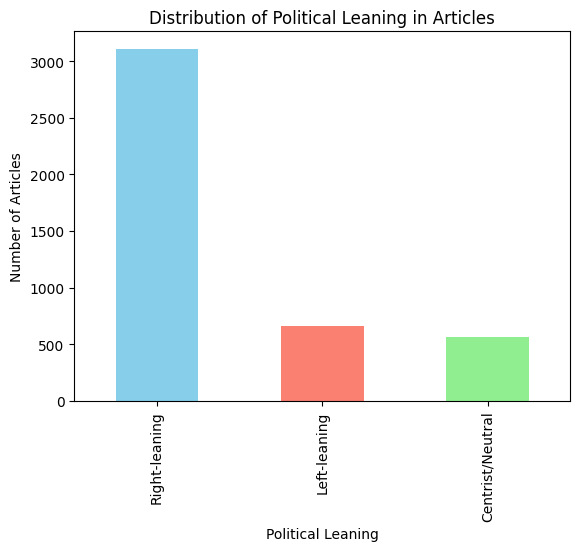

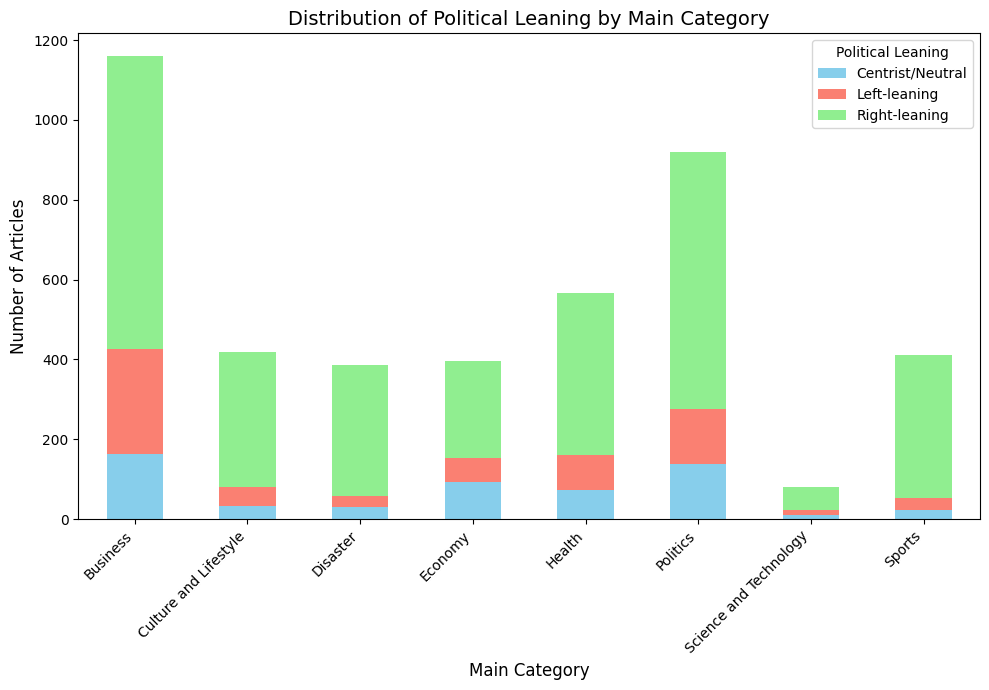

In [56]:
# Plot the distribution of political leanings
df['Political_Leaning'].value_counts().plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title("Distribution of Political Leaning in Articles")
plt.xlabel("Political Leaning")
plt.ylabel("Number of Articles")

# Group by 'Main Category' and 'Political_Leaning', then count occurrences
category_leaning_counts = df.groupby(['Main Category', 'Political_Leaning']).size().unstack(fill_value=0)

# Plotting the results
category_leaning_counts.plot(kind='bar', stacked=True, color=['skyblue', 'salmon', 'lightgreen'], figsize=(10, 7))

# Add titles and labels
plt.title("Distribution of Political Leaning by Main Category", fontsize=14)
plt.xlabel("Main Category", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.xticks(rotation=45, ha="right")  # Rotate x labels for better readability
plt.legend(title='Political Leaning', loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

In [57]:
# Save to CSV
df.to_csv("articles_with_political_leaning.csv", index=False)
print("Labeled data saved to articles_with_political_leaning.csv")

Labeled data saved to articles_with_political_leaning.csv


In [58]:
# prompt: download articles_with_political_leaning.csv

from google.colab import files
files.download('articles_with_political_leaning.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training the Model

In [4]:
df = pd.read_csv('articles_with_political_leaning.csv')

In [5]:
# Drop rows with missing required fields
df = df.dropna(subset=['Preprocessed_Text', 'Political_Leaning'])

# Normalize label text
df['Political_Leaning'] = df['Political_Leaning'].str.lower().str.strip()

# Updated label map (lowercase keys)
label_map = {
    'left-leaning': 0,
    'centrist/neutral': 1,
    'right-leaning': 2
}

# Filter and map
df = df[df['Political_Leaning'].isin(label_map.keys())]
df['label'] = df['Political_Leaning'].map(label_map)

# Check result
print(df.shape)
print(df['Political_Leaning'].value_counts())


(4338, 12)
Political_Leaning
right-leaning       3107
left-leaning         665
centrist/neutral     566
Name: count, dtype: int64


In [6]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Preprocessed_Text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label']  # keeps class proportions the same
)


In [7]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
import torch

class NewsBiasDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = NewsBiasDataset(train_encodings, train_labels)
val_dataset = NewsBiasDataset(val_encodings, val_labels)


In [9]:
from sklearn.utils.class_weight import compute_class_weight
import torch
import numpy as np

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert to tensor for use in the loss function
class_weights = torch.tensor(class_weights, dtype=torch.float)


In [10]:
from transformers import BertForSequenceClassification
from torch.nn import CrossEntropyLoss

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Define the custom loss function using class weights
def compute_loss_with_weights(model, inputs, return_outputs=False):
    labels = inputs.pop("labels")
    outputs = model(**inputs)
    loss_fct = CrossEntropyLoss(weight=class_weights.to(model.device))  # Apply class weights here
    loss = loss_fct(outputs.logits, labels)
    return (loss, outputs) if return_outputs else loss


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
import transformers
print(transformers.__version__)


4.51.3


In [79]:
!pip install --upgrade transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 106.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.1
    Uninstalling transformers-4.51.1:
      Successfully uninstalled transformers-4.51.1


In [17]:
class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # Forward pass
        outputs = model(**inputs)
        logits = outputs.logits

        # Get the device of the model (cuda or cpu)
        device = model.device

        # Compute loss using CrossEntropyLoss
        labels = inputs["labels"]

        # Make sure the weights tensor is on the same device as the model
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 3.0, 1.0]).to(device))  # Example class weights
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss



# Define training arguments (remove 'evaluation_strategy' for older versions)
training_args = TrainingArguments(
    output_dir='./results',               # Output directory
    num_train_epochs=3,                   # Number of epochs
    per_device_train_batch_size=8,        # Batch size per device during training
    per_device_eval_batch_size=8,         # Batch size per device during evaluation
    save_strategy="epoch",                # Save the model every epoch
    logging_dir='./logs',                 # Directory for logs
    logging_steps=10,                     # Log every 10 steps
    weight_decay=0.01,                    # Weight decay for regularization
    logging_first_step=True,              # Log the first step
)

# Initialize the custom trainer
trainer = CustomTrainer(
    model=model,                          # The model to train
    args=training_args,                   # Training arguments
    train_dataset=train_dataset,          # Training dataset
    eval_dataset=val_dataset,             # Validation dataset
)

# Start training
trainer.train()


Step,Training Loss
1,1.234100
10,1.014400
20,1.050200
30,0.937000
40,1.047400
50,1.037700
60,0.884600
70,0.990100
80,0.906600
90,0.726200


TrainOutput(global_step=1302, training_loss=0.8970643069520707, metrics={'train_runtime': 1021.1378, 'train_samples_per_second': 10.195, 'train_steps_per_second': 1.275, 'total_flos': 2739010678548480.0, 'train_loss': 0.8970643069520707, 'epoch': 3.0})

In [18]:
trainer.evaluate()


{'eval_loss': 0.7770209908485413,
 'eval_runtime': 23.644,
 'eval_samples_per_second': 36.711,
 'eval_steps_per_second': 4.61,
 'epoch': 3.0}

In [19]:
model.save_pretrained('./model')
tokenizer.save_pretrained('./model')


('./model/tokenizer_config.json',
 './model/special_tokens_map.json',
 './model/vocab.txt',
 './model/added_tokens.json')

In [22]:
import shutil
from google.colab import files
shutil.make_archive("model", 'zip', "./model")
files.download("model.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
from transformers import BertTokenizer, BertForSequenceClassification

model_path = "./model"  # or wherever you saved it
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)


In [26]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./model",               # Directory to save model checkpoints
    num_train_epochs=5,                 # Increase from 3 to 5 epochs
    per_device_train_batch_size=8,      # Training batch size
    per_device_eval_batch_size=8,       # Evaluation batch size
    logging_dir="./logs",               # Logging directory
    logging_steps=10,                   # How often to log
    do_eval=True,                       # Run evaluation after each epoch
    do_train=True,                      # Run training
    save_steps=500,                     # Save model every 500 steps
    logging_first_step=True             # Log the first step
)


In [28]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        outputs = model(**inputs)
        logits = outputs.logits
        labels = inputs["labels"]

        # Ensure class weights are on the correct device
        weights = torch.tensor([3.0, 1.0, 1.0]).to(logits.device)
        loss_fct = nn.CrossEntropyLoss(weight=weights)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

        # Use class weights: adjust based on your data distribution
        weights = torch.tensor([3.0, 1.0, 1.0]).to(logits.device)
        loss_fct = nn.CrossEntropyLoss(weight=weights)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

trainer = CustomTrainer(
    model=model,                          # BERT model already loaded
    args=training_args,                   # Updated training arguments
    train_dataset=train_dataset,          # Your prepared training data
    eval_dataset=val_dataset              # Your validation data
)

trainer.train()



Step,Training Loss
1,0.782200
10,0.911900
20,0.956200
30,0.819200
40,0.892300
50,0.874300
60,0.880400
70,0.836700
80,0.706600
90,0.934000


Step,Training Loss
1,0.782200
10,0.911900
20,0.956200
30,0.819200
40,0.892300
50,0.874300
60,0.880400
70,0.836700
80,0.706600
90,0.934000


TrainOutput(global_step=2170, training_loss=0.9262893164212802, metrics={'train_runtime': 1697.1412, 'train_samples_per_second': 10.223, 'train_steps_per_second': 1.279, 'total_flos': 4565017797580800.0, 'train_loss': 0.9262893164212802, 'epoch': 5.0})

In [29]:
trainer.evaluate()

{'eval_loss': 0.9123661518096924,
 'eval_runtime': 23.6973,
 'eval_samples_per_second': 36.629,
 'eval_steps_per_second': 4.6,
 'epoch': 5.0}

In [30]:
model.save_pretrained("./model_finetuned")
tokenizer.save_pretrained("./model_finetuned")


('./model_finetuned/tokenizer_config.json',
 './model_finetuned/special_tokens_map.json',
 './model_finetuned/vocab.txt',
 './model_finetuned/added_tokens.json')

In [36]:
import shutil
from google.colab import files
shutil.make_archive("model_finetuned", 'zip', "./model_finetuned")
files.download("model_finetuned.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
from sklearn.metrics import accuracy_score

# Predict on validation set
preds = trainer.predict(val_dataset).predictions.argmax(axis=-1)

# Access the labels from the val_dataset using the custom dataset class
labels = [item['labels'].item() for item in val_dataset]  # .item() to extract the scalar value from tensor

# Calculate accuracy
accuracy = accuracy_score(labels, preds)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.7166


In [33]:
from transformers import BertForSequenceClassification, BertTokenizer

model_path = "./model"

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)


In [34]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./model",  # Use the same folder as the loaded model
    per_device_eval_batch_size=8
)

trainer = Trainer(
    model=model,
    args=training_args,
)


In [35]:
from sklearn.metrics import accuracy_score
import numpy as np

outputs = trainer.predict(val_dataset)
preds = np.argmax(outputs.predictions, axis=1)

# Ground truth labels
labels = val_labels

# Compute and print accuracy
accuracy = accuracy_score(labels, preds)
print(f"Accuracy of 3-epoch model: {accuracy:.4f}")


Accuracy of 3-epoch model: 0.6866
